<a href="https://colab.research.google.com/github/szymanski52/cubism/blob/main/august17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset

In [50]:
from torchvision import transforms, datasets
import os
import zipfile
import torch.nn as nn
import gdown
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
from google.colab import files
from torchvision import datasets, models, transforms
import cv2 as cv
import numpy as np
import torch
from torch.nn.functional import relu6 as relu6

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/fashion.zip -d fashion
!rm -r fashion/__MACOSX

In [53]:
class CannyDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    image_names = os.listdir(root_dir)
    self.def_img = '01361d9b8bfdcc0c6801df23d60bc692.jpg'
    self.root_dir = root_dir
    self.transform = transform
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    try:
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    except:
        img_path = os.path.join(self.root_dir, self.def_img)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    canny = cv.Canny(img, 350, 400)
    canny = cv.cvtColor(canny, cv.COLOR_BGR2RGB)
    if self.transform:
        img = self.transform(Image.fromarray(img))
        canny = self.transform(Image.fromarray(canny))
    canny = torch.clamp(canny, 0, 1e-7) * 1e+7
    return img, canny

In [54]:
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')
image_size = 256
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])
canny_dataset = CannyDataset(f'fashion/fashion1024', transform)

batch_size = 40
num_workers = 0 if device.type == 'cuda' else 2
pin_memory = True if device.type == 'cuda' else False

canny_dataloader = torch.utils.data.DataLoader(canny_dataset,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               pin_memory=pin_memory,
                                               shuffle=True,
                                               drop_last=True
                                              )

In [107]:
item = canny_dataset.__getitem__(11390)
im = item[0]
target = item[1]

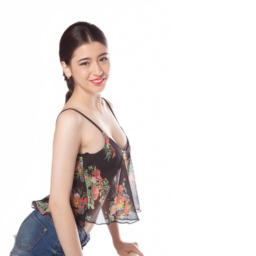

In [108]:
transforms.ToPILImage()(im)

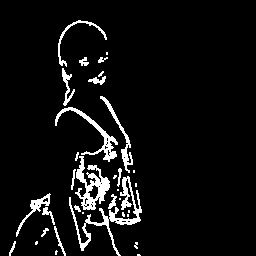

In [109]:
transforms.ToPILImage()(target)

#Model

In [58]:
def draw_line(c, out_size = 256, width = 1):
    e = torch.Tensor([[i for i in range(1,out_size+1)]]).to(device)
    e = e.repeat(out_size,1)
    e_x = e
    e_y = e.T
    if (c[1][1] - c[0][1]) * (c[1][0] - c[0][0]):
        kf = abs((c[1][1] - c[0][1]) / (c[1][0] - c[0][0]))
        if kf <= 1:
            if(c[1][0] < c[0][0]) and (c[1][1] < c[0][1]):
                d = width - torch.abs(e_y - (c[0][1] - c[1][1]) * (e_x - c[1][0]) / (c[0][0] - c[1][0]) - c[1][1])
                b1 = e_x - c[1][0] + 1
                b1 = torch.clamp(b1, 0, 1)
                b2 = c[0][0] - e_x + 1
                b2 = torch.clamp(b2, 0, 1)
            else:
                if (c[0][0] > c[1][0]) and (c[0][1] < c[1][1]):
                    d = width - torch.abs(e_y - (c[0][1] - c[1][1]) * (e_x - c[1][0]) / (c[0][0] - c[1][0]) - c[1][1])
                    b1 = e_x - c[1][0] + 1
                    b1 = torch.clamp(b1, 0, 1)
                    b2 = c[0][0] - e_x + 1
                    b2 = torch.clamp(b2, 0, 1)
                else:
                    d = width - torch.abs(e_y - (c[1][1] - c[0][1]) * (e_x - c[0][0]) / (c[1][0] - c[0][0]) - c[0][1])
                    b1 = e_x - c[0][0] + 1
                    b1 = torch.clamp(b1, 0, 1)
                    b2 = c[1][0] - e_x + 1
                    b2 = torch.clamp(b2, 0, 1)
        else:
            if(c[1][0] < c[0][0]) and (c[1][1] < c[0][1]):
                d = width - torch.abs(e_x - (c[0][0] - c[1][0]) * (e_y - c[1][1]) / (c[0][1] - c[1][1]) - c[1][0])
                b1 = e_y - c[1][1] + 1
                b1 = torch.clamp(b1, 0, 1)
                b2 = c[0][1] - e_y + 1
                b2 = torch.clamp(b2, 0, 1)
            else:
                if (c[0][0] < c[1][0]) and (c[0][1] > c[1][1]):
                    d = width - torch.abs(e_x - (c[0][0] - c[1][0]) * (e_y - c[1][1]) / (c[0][1] - c[1][1]) - c[1][0])
                    b1 = e_y - c[1][1] + 1
                    b1 = torch.clamp(b1, 0, 1)
                    b2 = c[0][1] - e_y + 1
                    b2 = torch.clamp(b2, 0, 1)
                else:
                    d = width - torch.abs(e_x - (c[1][0] - c[0][0]) * (e_y - c[0][1]) / (c[1][1] - c[0][1]) - c[0][0])
                    b1 = e_y - c[0][1] + 1
                    b1 = torch.clamp(b1, 0, 1)
                    b2 = c[1][1] - e_y + 1
                    b2 = torch.clamp(b2, 0, 1)
    elif not (c[1][0] - c[0][0]):
        d = width - torch.abs(e_x - c[0][0])
        b1 = max(c[0][1], c[1][1]) - e_y + 2
        b1 = torch.clamp(b1, 0, 1)
        b2 = e_y - min(c[0][1], c[1][1])
        b2 = torch.clamp(b2, 0, 1)
    else:
        if c[0][0] > c[1][0]:
            d = width - torch.abs(e_y - c[0][1])
            b1 = e_x - c[1][0] + 1
            b1 = torch.clamp(b1, 0, 1)
            b2 = c[0][0] - e_x + 1
            b2 = torch.clamp(b2, 0, 1)
        else:
            d = width - torch.abs(e_y - c[1][1])
            b1 = e_x - c[0][0] + 1
            b1 = torch.clamp(b1, 0, 1)
            b2 = c[1][0] - e_x + 1
            b2 = torch.clamp(b2, 0, 1)
    k = d * (d > 0)
    f = (k * b1 * b2).clamp(0, 1e-5) * 1e+5
    return f

In [59]:
from torch.nn import Module
from typing import Tuple, Union
from torch import Tensor
from torch.types import _size


class Render(Module):
    __constants__ = ['out_size', 'line_w']
    out_size: int
    line_w: int

    def __init__(self, out_size: int = 256, line_w: int = 10) -> None:
        super(Render, self).__init__()
        self.out_size = out_size
        self.line_w = line_w

    def forward(self, input: Tensor) -> Tensor:
        points = input.reshape(input.shape[0],20,2,2)
        silhouettes = torch.Tensor().to(device)
        for k in points:
            silhouette = torch.zeros((3, self.out_size, self.out_size)).to(device)
            for l in k:
                s = draw_line(l, width=self.line_w)
                silhouette[0] += s
                silhouette[1] += s
                silhouette[2] += s
            silhouettes = torch.cat((silhouettes, silhouette))
        silhouettes = silhouettes.resize(input.shape[0], 3,
                                         self.out_size,
                                         self.out_size)  
        return silhouettes


In [60]:
class LinesGenerator(nn.Module):
    def __init__(self, lines_n):
        self.points = None
        super(LinesGenerator, self).__init__()

        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features

        for i in self.resnet.parameters():
            i.requires_grad = False
        
        self.resnet.fc = nn.Linear(num_ftrs, num_ftrs)    

        self.fc1 = nn.Linear(num_ftrs, 1000)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)
        self.bn11 = nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, 750)
        self.relu5 = nn.LeakyReLU(0.2, inplace=True)
        self.bn12 = nn.BatchNorm1d(750)
        self.dropout3 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(750, 500)
        self.relu6 = nn.LeakyReLU(0.2, inplace=True)
        self.bn13 = nn.BatchNorm1d(500)
        self.fc4 = nn.Linear(500, 250)
        self.relu7 = nn.LeakyReLU(0.2, inplace=True)
        self.bn14 = nn.BatchNorm1d(250)
        self.dropout4 = nn.Dropout(0.3)

        self.fc7 = nn.Linear(250, lines_n * 4)
        self.relu10 = nn.LeakyReLU(0.2, inplace=True)
        self.bn17 = nn.BatchNorm1d(lines_n * 4)
        self.sigmoid = nn.Sigmoid()
        self.render = Render(line_w=2)

    def forward(self, X):
        x = self.resnet(X)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.bn11(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.bn12(x)
        x = self.dropout3(x)
        
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.bn13(x)
        x = self.fc4(x)
        x = self.relu7(x)
        x = self.bn14(x)
        x = self.dropout4(x)

        x = self.fc7(x)
        x = self.relu10(x)
        x = self.sigmoid(x)
        x = self.bn17(x)
        x = self.sigmoid(x)
        x = x * 255
        self.points = x
        x = self.render(x)
        return x

In [189]:
class LinesGenerator(nn.Module):
    def __init__(self, lines_n):
        self.points = None
        super(LinesGenerator, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 4, 2, 1)
        self.relu1 = nn.LeakyReLU(0.1, inplace=True)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(3, 3, 8, 2, 2)
        self.bn2 = nn.BatchNorm2d(3)
        self.bn3 = nn.BatchNorm3d(3)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(3, 3, 14, 1, 0)
        self.relu3 = nn.LeakyReLU(0.1, inplace=True)
        self.dropout2 = nn.Dropout(0.3)
        self.flatten = nn.Flatten()   

        self.fc1 = nn.Linear(7500, 7000)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn11 = nn.BatchNorm1d(7000)
        self.fc2 = nn.Linear(7000, 5000)
        self.relu5 = nn.LeakyReLU(0.2, inplace=True)
        self.bn12 = nn.BatchNorm1d(5000)
        self.dropout3 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(5000, 3000)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)
        self.bn13 = nn.BatchNorm1d(3000)
        self.fc4 = nn.Linear(3000, 1000)
        self.relu5 = nn.LeakyReLU(0.2, inplace=True)
        self.bn14 = nn.BatchNorm1d(1000)
        self.dropout3 = nn.Dropout(0.4)


        self.fc7 = nn.Linear(1000, lines_n * 4)
        self.relu10 = nn.LeakyReLU(0.1, inplace=True)
        self.bn17 = nn.BatchNorm1d(lines_n * 4)
        self.sigmoid = nn.Sigmoid()
        self.render = Render(line_w=2)

    def forward(self, X):
        x = self.conv1(X)
        x = self.relu1(x)
        x = self.bn2(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.relu1(x)
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.relu1(x)
        x = self.bn2(x)
        x = self.flatten(x)


        x = self.fc1(x)
        x = self.relu2(x)
        x = self.bn11(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn12(x)
        x = self.dropout3(x)

        x = self.fc3(x)
        x = self.relu1(x)
        x = self.bn13(x)
        x = self.dropout1(x)
        x = self.fc4(x)
        x = self.relu1(x)
        x = self.bn14(x)
        x = self.dropout3(x)

        x = self.fc7(x)
        x = self.relu10(x)
        x = self.bn17(x)
        x = self.sigmoid(x)
        x = x * 255
        self.points = x
        x = self.render(x)
        return x

In [223]:
model = LinesGenerator(20)
model.cuda()
try:
    #print('New model')
    state_dict = torch.load('drive/MyDrive/checkpoint2.pth')
    model.load_state_dict(state_dict)
except FileNotFoundError:
    print('Model load has failed')

#Discriminator

In [191]:
class ConvBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 bias=False,
                 inplace=True,
                 use_batch_norm=True):
        super(ConvBlock, self).__init__()

        layers = nn.ModuleList()
        layers.append(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=bias))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=inplace))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):

    def __init__(self, base_channels, in_channels):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            ConvBlock(in_channels, base_channels, 4, 2, 1),
            ConvBlock(base_channels, base_channels * 2, 4, 4, 1),
            ConvBlock(base_channels * 2, base_channels * 4, 4, 4, 1),
            ConvBlock(base_channels * 4, base_channels * 8, 4, 2, 1),
            nn.Conv2d(base_channels * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        return self.layers(x)

#Training

In [192]:
!pip3 install transformers
from transformers import AdamW

In [193]:
def weighted_loss(x, target, toleracy=0.3, penalty=100):
    criterion = nn.MSELoss(reduction='none')
    a = x
    b = target
    c = b * a
    l1 = criterion(c, b) * penalty
    d = (1 - b) * a
    l2 = criterion(d, b) * toleracy
    l = l1 + l2
    return l.mean()

In [194]:
discriminator_channels = 64

discriminator = Discriminator(discriminator_channels, 3)
if (device.type == 'cuda' and ngpu > 0):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

discriminator

DataParallel(
  (module): Discriminator(
    (layers): Sequential(
      (0): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (2): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=Tr

In [220]:
from torch.utils.data.dataset import random_split

EPOCHS = 10
LR = 1e-4
disc_LR = 1e-8
beta1 = 0.5
beta2 = 0.999
generator_losses = []
discriminator_losses = []

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=LR, eps=1e-8)
discriminator_optim = torch.optim.Adam(discriminator.parameters(),
                                       lr=disc_LR,
                                       betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1e-2, gamma=1e-6)
device = torch.device('cuda:0')
 
for epoch in range(1, EPOCHS + 1):
    for i, (img_batch, target_batch) in enumerate(canny_dataloader):
        discriminator.zero_grad()
        batch_size = target_batch.size(0)
        real_labels = (1.2 - 0.7) * torch.rand((batch_size,)) + 0.7
        real_labels = real_labels.to(device)
        target_batch = target_batch.to(device)
        output = discriminator(target_batch).view(-1)
        discriminator_real_loss = criterion(output, real_labels)
        discriminator_real_loss.backward()
        D_x = output.mean().item()

        fake_batch = model(target_batch)
        fake_labels = (0.3 - 0.0) * torch.rand((batch_size,)) + 0.0
        fake_labels = fake_labels.to(device)
        output = discriminator(fake_batch.detach()).view(-1)
        discriminator_fake_loss = criterion(output, fake_labels)
        discriminator_fake_loss.backward()
        D_G_z1 = discriminator_fake_loss.mean().item()
        discriminator_loss = discriminator_real_loss + discriminator_fake_loss
        discriminator_optim.step()

        model.zero_grad()
        output = discriminator(fake_batch).view(-1)
        gen_output = model(target_batch)
        generator_loss = criterion(output, real_labels)
        generator_w_loss = weighted_loss(gen_output, target_batch, 100, 1) * generator_loss
        generator_w_loss.backward()
        D_G_z2 = output.mean().item()
        optimizer.step()
        print(f'BATCH: {i+1}')
        if (i + 1) == 25: break
        discriminator_losses.append(discriminator_loss.item())
        generator_losses.append(generator_loss.item())
    if not epoch % 5:
        torch.save(model.state_dict(), 'drive/MyDrive/checkpoint2.pth')
    print(
        f'{epoch}: Loss_D:{discriminator_loss.item():4f} Loss_G:{generator_loss.item():4f} D(x):{D_x:4f} D(G(z)):{D_G_z1:4f}/{D_G_z2:4f}'
    )

torch.save(model.state_dict(), 'drive/MyDrive/checkpoint2.pth')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


BATCH: 1
BATCH: 2
BATCH: 3
BATCH: 4
BATCH: 5
BATCH: 6
BATCH: 7
BATCH: 8
BATCH: 9
BATCH: 10
BATCH: 11
BATCH: 12
BATCH: 13
BATCH: 14
BATCH: 15
BATCH: 16
BATCH: 17
BATCH: 18
BATCH: 19
BATCH: 20
BATCH: 21
BATCH: 22
BATCH: 23
BATCH: 24
BATCH: 25
1: Loss_D:0.403256 Loss_G:0.180071 D(x):0.490277 D(G(z)):0.167738/0.555451
BATCH: 1
BATCH: 2
BATCH: 3
BATCH: 4
BATCH: 5
BATCH: 6
BATCH: 7
BATCH: 8
BATCH: 9
BATCH: 10
BATCH: 11
BATCH: 12
BATCH: 13
BATCH: 14
BATCH: 15
BATCH: 16
BATCH: 17
BATCH: 18
BATCH: 19
BATCH: 20
BATCH: 21
BATCH: 22
BATCH: 23
BATCH: 24
BATCH: 25
2: Loss_D:0.442050 Loss_G:0.180742 D(x):0.512200 D(G(z)):0.218599/0.562924
BATCH: 1
BATCH: 2
BATCH: 3
BATCH: 4
BATCH: 5
BATCH: 6
BATCH: 7
BATCH: 8
BATCH: 9
BATCH: 10
BATCH: 11
BATCH: 12
BATCH: 13
BATCH: 14
BATCH: 15
BATCH: 16
BATCH: 17
BATCH: 18
BATCH: 19
BATCH: 20
BATCH: 21
BATCH: 22
BATCH: 23
BATCH: 24
BATCH: 25
3: Loss_D:0.456182 Loss_G:0.168414 D(x):0.497289 D(G(z)):0.208340/0.586415
BATCH: 1
BATCH: 2
BATCH: 3
BATCH: 4
BATCH: 5
BATCH: 

#Results

In [221]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


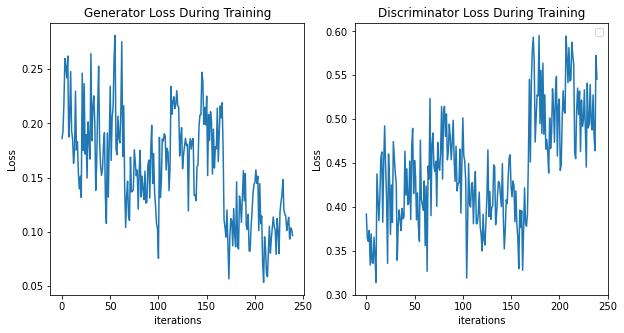

In [222]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Generator Loss During Training")
plt.plot(generator_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.title("Discriminator Loss During Training")
plt.plot(discriminator_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Evaluation

In [198]:
def check_by_index(model, index):
    item = canny_dataset.__getitem__(index)
    im = item[0]
    target = item[1]
    model.eval()
    out = model(im.to(device).unsqueeze(0))
    print(model.points)
    img = transforms.ToPILImage()(out[0])
    loss = criterion(out[0], (target).to(device))
    print(criterion._get_name(), loss)
    return img, transforms.ToPILImage()(out[0]+target.to(device)), out, transforms.ToPILImage()(target)

In [216]:
criterion = nn.MSELoss()
res = check_by_index(model, 19390)

tensor([[ 79.8301,  75.1928,  57.0127, 254.2853, 254.3718,  93.8013,  86.3812,
         216.8847,  83.4151,  98.7758,  80.0977,  49.5230,  25.8358,  25.4987,
          36.8050,  71.6857, 254.6478,  56.0812, 252.9739, 254.8813, 151.5805,
          88.4707,  75.5773, 254.9260, 252.7540, 179.1629,  84.8681,  74.4672,
         254.9613,  35.6724, 104.7035, 241.6973,  92.6273, 253.0944,  87.1947,
          41.2979,  71.2855, 244.0101, 254.8034, 226.3545,  80.0274,  61.3650,
          69.9618,  58.0873,  47.5097,  84.2796, 224.3900,  52.6066, 250.9386,
         254.9309,  94.2672, 253.5678,  58.2932, 253.7330,  37.8854, 253.9611,
          31.3139,  37.4143,  80.8113, 254.2059, 241.7065, 252.8824, 247.1947,
          67.3074, 239.8883, 251.4075, 254.4168, 233.2750, 247.4676,  58.6904,
          80.0171,  90.1171, 253.5813,  73.1881,  37.4321, 240.2137, 251.6294,
         219.3718, 252.6181,  64.5543]], device='cuda:0',
       grad_fn=<MulBackward0>)
MSELoss tensor(0.2367, device='cuda:0', gr

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


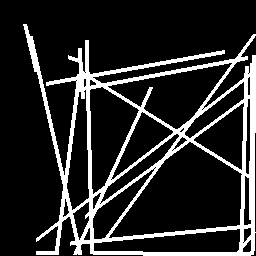

In [217]:
res[0]

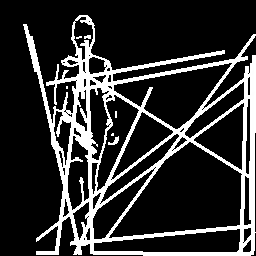

In [218]:
res[1]

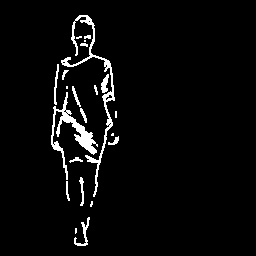

In [219]:
res[3]